In [1]:
import math
import os
import random
from pathlib import Path
import numpy as np
import yaml
import glob
import cv2
import torch
from pathlib import Path
import pandas as pd

In [152]:
def img2label_paths(img_paths):
    # Define label paths as a function of image paths
    sa, sb = f'{os.sep}images{os.sep}', f'{os.sep}labels{os.sep}'  # /images/, /labels/ substrings
    return [sb.join(x.rsplit(sa, 1)).rsplit('.', 1)[0] + '.txt' for x in img_paths]
def myLoadImage(i, im_files, augment=True) :
    f = im_files[i]
    im = cv2.imread(f)
    h0, w0 = im.shape[:2]
    r = img_size / max(h0, w0)
    if r != 1:  # if sizes are not equal
        interp = cv2.INTER_LINEAR if augment else cv2.INTER_AREA  # random.choice(self.rand_interp_methods)
        im = cv2.resize(im, (int(w0 * r), int(h0 * r)), interpolation=interp)
    return im, (h0, w0), im.shape[:2] 
def xywhn2xyxy(x, w=640, h=640, padw=0, padh=0):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = w * (x[:, 0] - x[:, 2] / 2) + padw  # top left x
    y[:, 1] = h * (x[:, 1] - x[:, 3] / 2) + padh  # top left y
    y[:, 2] = w * (x[:, 0] + x[:, 2] / 2) + padw  # bottom right x
    y[:, 3] = h * (x[:, 1] + x[:, 3] / 2) + padh  # bottom right y
    return y
def xyxy2xywhn(x, w=640, h=640, clip=False, eps=0.0):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] normalized where xy1=top-left, xy2=bottom-right
    if clip:
        clip_coords(x, (h - eps, w - eps))  # warning: inplace clip
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = ((x[:, 0] + x[:, 2]) / 2) / w  # x center
    y[:, 1] = ((x[:, 1] + x[:, 3]) / 2) / h  # y center
    y[:, 2] = (x[:, 2] - x[:, 0]) / w  # width
    y[:, 3] = (x[:, 3] - x[:, 1]) / h  # height
    return y
def noPad(label, xc, yc, xmin, ymin) :
    label4_ = label.copy()
    if ((xc>s) & (yc<s)) :
        label4_[:,1] = label4_[:,1] - xmin
        label4_[:,3] = label4_[:,3] - xmin
    elif ((xc<s) & (yc>s)) :
        label4_[:,2] = label4_[:,2] - ymin
        label4_[:,4] = label4_[:,4] - ymin
    elif ((xc>s) & (yc>s)) :
        label4_[:,1] = label4_[:,1] - xmin
        label4_[:,3] = label4_[:,3] - xmin
        label4_[:,2] = label4_[:,2] - ymin
        label4_[:,4] = label4_[:,4] - ymin
    return label4_

from PIL import Image, ImageDraw
import matplotlib.patches as patches
def myFig(img, bbox, drawB = True) :
    image = Image.fromarray(img,"RGB")
    draw = ImageDraw.Draw(image)

    if drawB :
        for i in range(len(bbox)) :
            xmin = bbox[i][1] 
            ymin = bbox[i][2]
            xmax = bbox[i][3]
            ymax = bbox[i][4]

            draw.rectangle((xmin, ymin, xmax, ymax), outline=(255,0,0), width = 1) # bounding box
#     display(image)
    return image

In [204]:
img_size = 64
# path = '/data/ij/Mosaic_data_augmentation_YOLO/coco128/images/train2017'
path = '/data/ij/Mosaic_data_augmentation_YOLO/images'
im_files = np.array([i for i in os.listdir(path) if i.endswith("png")], dtype = "object")
im_files = list(path + "/" + im_files)
label_files = img2label_paths(im_files) 
n = len(im_files)
indices_ = range(n)

img.shape : (64, 64, 3)
[32, 32]
64
126 89
labels1 : [[0.  0.5 0.5 1.  1. ]]
labels1.size : 5
labels : [[  0.  43.   0. 107.  64.]]


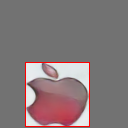

In [205]:
s = img_size
index = 0
img, (h0, w0), (h, w) = myLoadImage(index,im_files)
print(f'img.shape : {img.shape}')
img1 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8) 

mosaic_border = [img_size // 2, img_size // 2]
labels4 = []
print(mosaic_border)
print(s)

yc, xc = (int(random.uniform(64, 2 * s)) for x in mosaic_border)  
print(yc, xc)
i = 0
if i == 0:  # top left
    img1 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
    x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
    x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)

    xmin, ymin = x1a, y1a
    
img1[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]

padw = x1a - x1b
padh = y1a - y1b

# Labels
labels1 = np.loadtxt(label_files[index], ndmin=2)
print(f'labels1 : {labels1}')
print(f'labels1.size : {labels1.size}')
if labels1.size:
    labels1[:, 1:] = xywhn2xyxy(labels1[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
    labels1[labels1 < 0] = 0
    labels1[labels1 > s*2] = s*2
    print(f'labels : {labels}')
# labels4.append(labels1)
# labels_ = np.loadtxt(label_files[index], ndmin=2)
# print(f'labels_ : {labels_}')
# labels_[:, 1:] = xywhn2xyxy(labels_[:, 1:], w, h)  
# print(f'labels_ : {labels_}')
# print(f'labels : {labels}')
myFig(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), labels1)

[32, 32]
64
125 76
labels2 : [[0.  0.5 0.5 1.  1. ]]
labels2.size : 5
labels2 : [[  0.  12.  61.  76. 125.]]


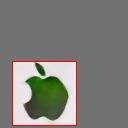

In [188]:
s = img_size
index = 1
img, (h0, w0), (h, w) = myLoadImage(index,im_files)
img2 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8) 

mosaic_border = [img_size // 2, img_size // 2]
labels4 = []
print(mosaic_border)
print(s)

yc, xc = (int(random.uniform(64, 2 * s)) for x in mosaic_border)  
print(yc, xc)
i = 0
if i == 0:  # top left
    img2 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
    x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
    x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)

    xmin, ymin = x1a, y1a
    
img2[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]

padw = x1a - x1b
padh = y1a - y1b

# Labels
labels2 = np.loadtxt(label_files[index], ndmin=2)
print(f'labels2 : {labels2}')
print(f'labels2.size : {labels2.size}')
if labels2.size:
    labels2[:, 1:] = xywhn2xyxy(labels2[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
    labels2[labels2 < 0] = 0
    labels2[labels2 > s*2] = s*2
    print(f'labels2 : {labels2}')
# labels4.append(labels)
# labels_ = np.loadtxt(label_files[index], ndmin=2)
# print(f'labels_ : {labels_}')
# labels_[:, 1:] = xywhn2xyxy(labels_[:, 1:], w, h)  
# print(f'labels_ : {labels_}')
# print(f'labels : {labels}')
myFig(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), labels2)

In [189]:
img2.shape

(128, 128, 3)

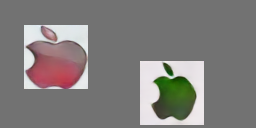

In [190]:

save_img = np.concatenate((img1,img2),axis=1)
myFig(cv2.cvtColor(save_img, cv2.COLOR_BGR2RGB), [])





[[  0. 140.  61. 204. 125.]]


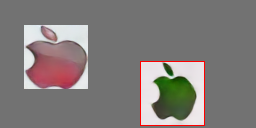

In [191]:
labels2[0][1] += 128
labels2[0][3] += 128
print(labels2)
myFig(cv2.cvtColor(save_img, cv2.COLOR_BGR2RGB), labels2)

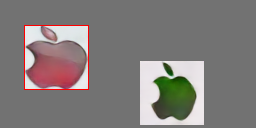

In [192]:
myFig(cv2.cvtColor(save_img, cv2.COLOR_BGR2RGB), labels1)

[32, 32]
64
113 93
labels3 : [[0.  0.5 0.5 1.  1. ]]
labels3.size : 5
labels3 : [[  0.  29.  49.  93. 113.]]


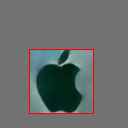

In [193]:
s = img_size
index = 2
img, (h0, w0), (h, w) = myLoadImage(index,im_files)
img3 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8) 

mosaic_border = [img_size // 2, img_size // 2]
labels4 = []
print(mosaic_border)
print(s)

yc, xc = (int(random.uniform(64, 2 * s)) for x in mosaic_border)  
print(yc, xc)
i = 0
if i == 0:  # top left
    img2 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
    x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
    x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)

    xmin, ymin = x1a, y1a
    
img3[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]

padw = x1a - x1b
padh = y1a - y1b

# Labels
labels3 = np.loadtxt(label_files[index], ndmin=2)
print(f'labels3 : {labels3}')
print(f'labels3.size : {labels3.size}')
if labels3.size:
    labels3[:, 1:] = xywhn2xyxy(labels3[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
    labels3[labels3 < 0] = 0
    labels3[labels3 > s*2] = s*2
    print(f'labels3 : {labels3}')
# labels4.append(labels)
# labels_ = np.loadtxt(label_files[index], ndmin=2)
# print(f'labels_ : {labels_}')
# labels_[:, 1:] = xywhn2xyxy(labels_[:, 1:], w, h)  
# print(f'labels_ : {labels_}')
# print(f'labels : {labels}')
myFig(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB), labels3)

In [194]:

labels3[0][2] += 128
labels3[0][4] += 128
print(labels3)

[[  0.  29. 177.  93. 241.]]


[32, 32]
64
96 74
labels4 : [[0.  0.5 0.5 1.  1. ]]
labels4.size : 5
labels4 : [[ 0. 10. 32. 74. 96.]]


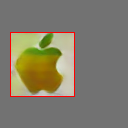

In [195]:
s = img_size
index = 3
img, (h0, w0), (h, w) = myLoadImage(index,im_files)
img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8) 

mosaic_border = [img_size // 2, img_size // 2]
labels4 = []
print(mosaic_border)
print(s)

yc, xc = (int(random.uniform(64, 2 * s)) for x in mosaic_border)  
print(yc, xc)
i = 0
if i == 0:  # top left
    img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
    x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
    x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)

    xmin, ymin = x1a, y1a
    
img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]

padw = x1a - x1b
padh = y1a - y1b

# Labels
labels4 = np.loadtxt(label_files[index], ndmin=2)
print(f'labels4 : {labels4}')
print(f'labels4.size : {labels4.size}')
if labels4.size:
    labels4[:, 1:] = xywhn2xyxy(labels4[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
    labels4[labels4 < 0] = 0
    labels4[labels4 > s*2] = s*2
    print(f'labels4 : {labels4}')
# labels4.append(labels)
# labels_ = np.loadtxt(label_files[index], ndmin=2)
# print(f'labels_ : {labels_}')
# labels_[:, 1:] = xywhn2xyxy(labels_[:, 1:], w, h)  
# print(f'labels_ : {labels_}')
# print(f'labels : {labels}')
myFig(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB), labels4)

In [196]:
labels4[0][1] += 128
labels4[0][2] += 128
labels4[0][3] += 128
labels4[0][4] += 128
print(labels4)


[[  0. 138. 160. 202. 224.]]


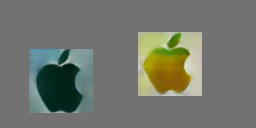

In [197]:

save_img2 = np.concatenate((img3,img4),axis=1)
myFig(cv2.cvtColor(save_img2, cv2.COLOR_BGR2RGB), labels3)


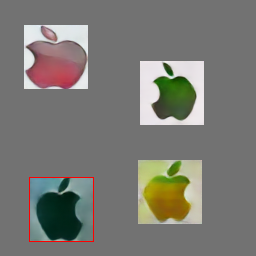

In [198]:
save_img3 = np.concatenate((save_img,save_img2),axis=0)
myFig(cv2.cvtColor(save_img3, cv2.COLOR_BGR2RGB), labels3)

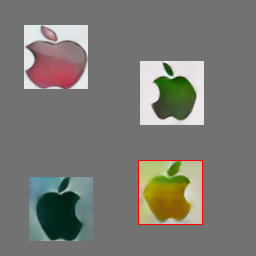

In [199]:
myFig(cv2.cvtColor(save_img3, cv2.COLOR_BGR2RGB), labels4)

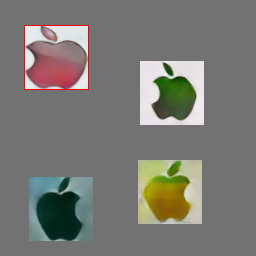

In [201]:
myFig(cv2.cvtColor(save_img3, cv2.COLOR_BGR2RGB), labels1)

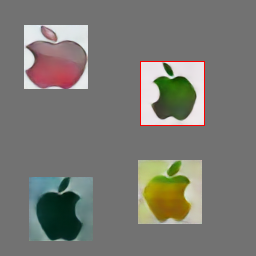

In [202]:
myFig(cv2.cvtColor(save_img3, cv2.COLOR_BGR2RGB), labels2)

(128, 128, 3)
[[  0.  43.   0. 107.  64.]]


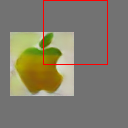

In [200]:
def resize(im, img_size,augment=True):
    h0, w0 = im.shape[:2]
    r = img_size / max(h0, w0)
    if r != 1:  # if sizes are not equal
        interp = cv2.INTER_LINEAR if augment else cv2.INTER_AREA  # random.choice(self.rand_interp_methods)
        im = cv2.resize(im, (int(w0 * r), int(h0 * r)), interpolation=interp)
    return im, (h0, w0), im.shape[:2] 


i = 1
index = 1
img_size = 128
img, (h0, w0), (h, w) = resize(img4,img_size)
print(img.shape)
print(labels)

myFig(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), labels)

In [124]:

# x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
# x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
# # img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]

# padw = x1a - x1b
# padh = y1a - y1b

# # Labels
# labels = np.loadtxt(label_files[index], ndmin=2)

# if labels.size:
#     labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h, padw, padh)  # normalized xywh to pixel xyxy format
#     labels[labels < 0] = 0
#     labels[labels > s*2] = s*2
# labels4.append(labels)
# labels_ = np.loadtxt(label_files[index], ndmin=2)
# labels_[:, 1:] = xywhn2xyxy(labels_[:, 1:], w, h)  
# myFig(cv2.cvtColor(save_img, cv2.COLOR_BGR2RGB), labels)